#  CNN(Tensorflow)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.python.framework import ops

from utils import random_mini_batche_v2

Using TensorFlow backend.


![](../../picture/tf_CONV.png)

这里我们使用Minist手写数据集,该模型是依据Tensorflow的官方案例而衍生出来的模型.下面我就来看看如何使用Tensorflow来完成该模型.

## Load Data 

这里我们依然使用Keras数据集中的mnist,需要注意的是,为了模型运行效率(CPU),我这里只使用了10K的train set,以及0.1K的validation set.

**Ps:**

- 原minis数据集大小: train set:60K,validation set 10K.

In [2]:
def Load_data(index,limit_train,limit_test):
    """
    Load data set.
    Arguments:
    ---------
        index: show minist digits index.
        limit_train: sample limit of training set,in this case, choose 10K.
        limit_test: sample limit of validation set,in this case,choose 0,1K.
    Returns:
    -------
        x_train: training data set. divide by 255.-->normal
        x_test: testing data set. divide by 255.-->normal
        y_train: training data labels. It's a hot vector, shape is (m,n_classes).
        y_test: testing data labels,a hot vector,shape is (m,n_classes).
    """
    (X_train,Y_train),(X_test,Y_test) = mnist.load_data()
    x_train = X_train[:limit_train,...].reshape(-1,28,28,1)
    x_test = X_test[:limit_test,...].reshape(-1,28,28,1)
    
    n_classes = len(np.unique(Y_train))
    y_train = np.eye(n_classes)[Y_train[:limit_train,...]]
    y_test = np.eye(n_classes)[Y_test[:limit_test,...]]
    
    print('x_train reshape:\n',x_train.shape)
    print('x_test reshape:\n',x_test.shape)
    print('Hot y_train shape:\n ',y_train.shape)
    print('Hot y_test shape:\n ',y_test.shape)
    print('The Number is:{}'.format(Y_train[index]))
    plt.imshow(X_train[index],cmap='gray')
    plt.show()
    
    return x_train/255,x_test/255,y_train,y_test

x_train reshape:
 (10000, 28, 28, 1)
x_test reshape:
 (100, 28, 28, 1)
Hot y_train shape:
  (10000, 10)
Hot y_test shape:
  (100, 10)
The Number is:5


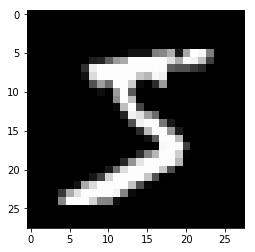

In [3]:
x_train,x_test,y_train,y_test = Load_data(0,10000,100)

可以看到原图展示的效果,接下去我们就要开始搭建CNN模型.

## Build CNN Model

### Initialization Parameters

这里我们只初始化卷积层的$Weights,Bias$.因为我们全连接层使用的是

[tf.contrib.layers.fully_connected](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected):

- 该函数会自动创建一个符合大小的$Weights$,并且默认使用```xavier_initializer```初始化.

- 该函数会自动创建一个符合大小的$bias$,并且默认使用```zeros_initializer```初始化.

我们只需要按照```[batch_size, depth]```的形状输入即可.

In [4]:
def init_parameters():
    """
    Initialization Parameters.
    
    Arguments:
    ---------
        None.
    
    Returns:
    -------
        parameters_cache: cache parameters incloud W1,b1,W2,b2
    
    Note:
    ----
        W1: 5,5,1,32
        b1: 1,1,32
        W2: 5,5,32,64
        b2: 1,1,64
        for example; W1 shape (f_h,f_w,f_c,#f),notic,the f_c must equal input n_c.
    """
    tf.set_random_seed(234)
    initial_W = tf.keras.initializers.he_normal(1)
    initial_b = tf.keras.initializers.zeros()
    W1 = tf.get_variable('W1',[5,5,1,32],initializer=initial_W)
    b1 = tf.get_variable('b1',[1,1,32],initializer=initial_b)
    W2 = tf.get_variable('W2',[5,5,32,64],initializer=initial_W)
    b2 = tf.get_variable('b2',[1,1,64],initializer=initial_b)
    
    parameters_cache = (W1,b1,W2,b2)
    
    return parameters_cache

### Forward

现在我们创建Forward Propagation.

模型流程为:

Input-->CONV1(28x28x32)-->POOL1(28x28x32)-->CONV2(28x28x64)-->POOl2(28x28x64)-->FC3(1024)-->Output(10).

1) 在使用TF的[tf.nn.conv2d](https://www.tensorflow.org/versions/r1.9/api_docs/python/tf/nn/conv2d?hl=en)函数的时候,我们需要注意以下几点.
- 0.默认的数据输入形式为```data_format:NHWC```,也就是Number of sample, Height of sample,Width of sameple. Channels of samepl.

- 1.input的输入为:```[batch, in_height, in_width, in_channels]```.

- 2.kernel的输入为:```[filter_height, filter_width, in_channels, out_channels]```.

- 3.可以自己更改输入的形式```data_format:"NHWC", "NCHW"```

- 4.padding可已选择```SAME```或者```VALID```.

- 5.strides的输入极为重要,其根据的是```data_format```的选择而言的,因为我们这里选择的是```NHWC```,strides是在```HW```上滑动,所以剩余维度的步长为1,```HW```维度的步长为s,比如我们的s=2,那么```strides=[1,2,2,1]```.

2) 在使用[tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)函数的时候需要注意以下几点:

- 0.输入的形状与```data_format```一致.

- 1.卷积核ksize与strides是一致的,依照data_format而言,比如我们的选择的是```NHWC```,那么卷积核的大小也只有在```HW```上,其他维度都为1.比如我们选择$F=2$的卷积核:```ksize=[1,2,2,1]```.

3) [tf.contrib.layers.flatten](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten):将数据展平为```[batch_size,...]```的形式,也就是说batch size 先行.

4) [tf.nn.dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout):使用Dropout,在训练的过程中防止过拟合,需要注意的是:

![](../../picture/173.png)

也就是说,我们不能使用```keep_prob```,按照官方给出的建议,我们应该选择使用```rate```也就是删除率,亦即```rate=1-keep_prob```.

5) 在最后一个全连接层的时候,我们一定不能使用activation,也就是设置```activation_fn=None```,因为我们接下去使用的loss函数是```tf.nn.softmax_cross_entropy_with_logits_v2```,其会将非线性值自动求softmax与损失,所以我们要保证最后一个全连接层为**non-linear!.**

In [8]:
def forward(data,parameters,rate):
    """
    Forward Propagation of CNN model.
    
    Arguments:
    ---------
        data: training data set,it's a place holder,the shape is (batch_size,height,width,channels).
        parameters: include weights and bias.
        rate: dropout rate, it's equal 1-keep_prob.
        
    Retrurns:
    --------
        A4: Output layers value,It's a non-linear, the shape is (m,n_classes).
    """
    (W1,b1,W2,b2) = parameters
    # CONV1
    Z1 = tf.nn.conv2d(data,W1,[1,1,1,1],padding='SAME',name='CONV1') + b1
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME",name='POOL1')
    # CONV2
    Z2 = tf.nn.conv2d(P1,W2,[1,1,1,1],padding="SAME",name='CONV2') + b2
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',name='POOL2')
    # Flatten
    flatten = tf.contrib.layers.flatten(P2)
    # FC3
    A3 = tf.contrib.layers.fully_connected(flatten,1024)
    A3_drop = tf.nn.dropout(A3,rate=rate)
    
    # FC4 its a non-linear output.
    A4 = tf.contrib.layers.fully_connected(A3_drop,10,activation_fn=None)
    
    return A4

现在我们来测试训练集的前100个样本,看看Forward能否走通.

In [13]:
tf.reset_default_graph()
with tf.Session() as sess:
    X_tensor = tf.placeholder(tf.float32,[None,28,28,1],name='Input')
    rate = tf.placeholder(tf.float32)
    parameters_cache = init_parameters()
    A5 = forward(X_tensor,parameters_cache,rate)
    init = tf.global_variables_initializer()
    sess.run(init)
    out = sess.run(A5,feed_dict={X_tensor:x_train[:100],rate:0.3})
    print(out.shape)

(100, 10)


OK,那么现在已经走通了Forward,我们开始构建CNN Model.

### Build CNN Model

我们选择使用Adam Optimizer,学习率lr设置为1e-4,Batch_size设置为100.迭代次数epochs设置为6

In [11]:
def CNN_Model(data,labels,val_data,val_labels,epochs,lr,BATC_SIZE):
    """
    Build CNN Model.
    
    Arguments:
    ---------
        data: training data set,shape is (m,n_h,n_w,n_c).
        labels: training data labels,shape is (m,n_classes).
        val_data: validation data set,shape like data shape.
        val_labels:validation data set,shape like labels shape.
        epochs: number of iterate.
        lr: learning rate. I choose 1e-4.
        BATC_SIZE: sample batch size of every epoch.
    
    """
    ops.reset_default_graph() # reset graph.
    m,n_h,n_w,n_c = data.shape
    n_classes = labels.shape[1]
    # Create place holder .
    X = tf.placeholder(tf.float32,(None,n_h,n_w,n_c),name="Input")
    y = tf.placeholder(tf.float32,(None,10),name="Labels")
    rate = tf.placeholder(tf.float32,name="rate")
    
    # Forward
    parameters = init_parameters()
    out = forward(X,parameters,rate)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,labels=y))
    optimizer = tf.train.AdamOptimizer(lr).minimize(cost)
    
    # caculate accuracy.
    prediction = tf.nn.softmax(out,axis=1)
    correct = tf.equal(tf.argmax(y,axis=1),tf.argmax(prediction,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
    init = tf.global_variables_initializer()
    seed = 0
    
    # Start training model and in each  epoch to print loss and accuracy.
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            mini_btahcs = random_mini_batche_v2(data,labels,BATC_SIZE,seed)
            
            for mini_x,mini_y in mini_btahcs:
                _ = sess.run(optimizer,feed_dict={X:mini_x,y:mini_y,rate:0.3})
            
            if epoch % 1==0:
                acc_train,loss_train = sess.run([accuracy,cost],feed_dict={X:data,y:labels,rate:0.})
                acc_val,loss_val = sess.run([accuracy,cost],feed_dict={X:val_data,y:val_labels,rate:0.})
                print('[{}/{}] Train acc:{:.4f} Train Loss:{:.4f} Val acc:{:.4f} Val Loss:{:.4f}'.format(epoch+1,
                                                                                         epochs,
                                                                                         acc_train,
                                                                                         loss_train,
                                                                                         acc_val,
                                                                                         loss_val
                                                                                        ))

In [12]:
CNN_Model(x_train,y_train,x_test,y_test,6,lr=1e-4,BATC_SIZE=100)

[1/6] Train acc:0.9264 Train Loss:0.2455 Val acc:0.9700 Val Loss:0.1939
[2/6] Train acc:0.9609 Train Loss:0.1412 Val acc:0.9700 Val Loss:0.1193
[3/6] Train acc:0.9750 Train Loss:0.0940 Val acc:0.9800 Val Loss:0.0804
[4/6] Train acc:0.9826 Train Loss:0.0699 Val acc:0.9800 Val Loss:0.0593
[5/6] Train acc:0.9869 Train Loss:0.0553 Val acc:0.9900 Val Loss:0.0418
[6/6] Train acc:0.9889 Train Loss:0.0478 Val acc:0.9900 Val Loss:0.0319


可以看到相比与之前的DNN,CNN在4个epoch的时候就已经能达到很高的正确率,并且训练样本与验证样本之前也没有发现过拟合现象.